In [2]:
from __future__ import print_function
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from numpy import random
from random import sample
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras
#from tabulate import tabulate
plt.style.use('ggplot')
import os
import pandas as pd
import plotly.express as px
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [3]:
os.chdir('C:/Users/rishv/OneDrive/Northeastern/SEM3/Algorithmic Digital Marketing/Assignments/Assignment1-2/criteo_attribution_dataset')

In [4]:
data_file='criteo_attribution_dataset.tsv.gz'
df_Criteo_Attribution = pd.read_csv(data_file, sep='\t', compression='gzip')

In [5]:
n_campaigns = 400

## Initial data preparation

Step 1: Deriving JID (JourneyId: concatenation of the user ID and conversion ID) and standartize timestamps

In [6]:
def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

In [7]:
df_Criteo_Attribution = add_derived_columns(df_Criteo_Attribution)

In [8]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,3490278,29196072,11409686,1973606,25162884,29196072,29196072,20073966_-1,0.000000e+00,0.000000
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,14584482,29196072,11409686,1973606,22644417,9312274,21091111,24607497_-1,7.487274e-07,0.163526
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,10769841,29196072,5824237,138937,1795451,29196072,15351056,28474333_-1,7.487274e-07,0.003426
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,12435261,23549932,5824237,1973606,9180723,29841067,29196072,7306395_3063962,1.123091e-06,0.000000
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,31616034,29196072,11409684,26597096,4480345,29196072,29196072,25357769_-1,1.123091e-06,0.000000


Step 2:Reducing the dataset size by randomly sampling 400 campaigns and filtering out journeys with just one event to focus on sequence analysis

In [22]:
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]


In [23]:
def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]


In [24]:
df_Criteo_Attribution = sample_campaigns(df_Criteo_Attribution, n_campaigns)
df_Criteo_Attribution = filter_journeys_by_length(df_Criteo_Attribution, 2)

In [25]:
df_Criteo_Attribution.shape

(563730, 27)

Step 3: The original dataset is imbalanced because conversion events are very rare. So, we balance the dataset by downsampling non-converted journeys

In [26]:
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

In [27]:
df_Criteo_Attribution=balance_conversions(df_Criteo_Attribution)

In [28]:
df_Criteo_Attribution.shape

(563730, 27)

Step 4: One-hot encoding for categorical fields (categories and campaigns). The total number of features after one-hot encoding is about 1,500

In [29]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext

In [30]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

In [31]:
df_Criteo_Attribution.cats[0]

array([1., 0., 0., ..., 0., 0., 0.])

In [32]:
df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [33]:
df_Criteo_Attribution.campaigns[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
print(df_Criteo_Attribution.shape[0])
print([df_Criteo_Attribution[df_Criteo_Attribution.conversion == 0].shape[0], df_Criteo_Attribution[df_Criteo_Attribution.conversion == 1].shape[0]])

563730
[282527, 281203]


## Data Exploration

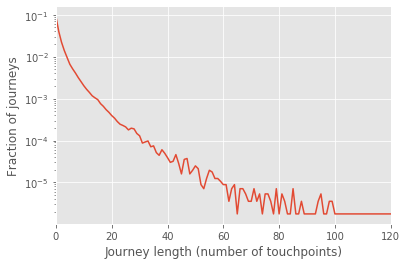

In [35]:
def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df_Criteo_Attribution)

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

We observe that the number of journeys falls exponentially with the length of journey

## Attribution Models
An attribution model is the rule, or set of rules, that determines how conversion credit is assigned to different marketing touchpoints. Attribution models can be single-touch or multi-touch

### Single-Touch Attribution Models

* Single-touch attribution models assign 100% of conversion credit to one marketing touchpoint. Even if a customer saw 20 ads before converting, single-touch attribution will determine that only 1 of the 20 ads deserves conversion credit.
* Single-touch attribution models are easy to implement because of their low level of complexity. They’re also the most popular attribution models because of their historical tie to Google Ads
* The models are
    1. First Touch Attribution (FTA)
    2. Last Touch Attribution (LTA)

### First Touch Attribution

* The First Touch model gives 100% of the credit to the marketing effort that drove a visitor to your website for the first time.
* Because it gives all the credit on the basis of a single touchpoint, it will naturally overemphasize a single part of the funnel. In this case, the First Touch model overemphasizes the top-of-the-funnel marketing channels that drive awareness.

In [88]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df_Criteo_Attribution)

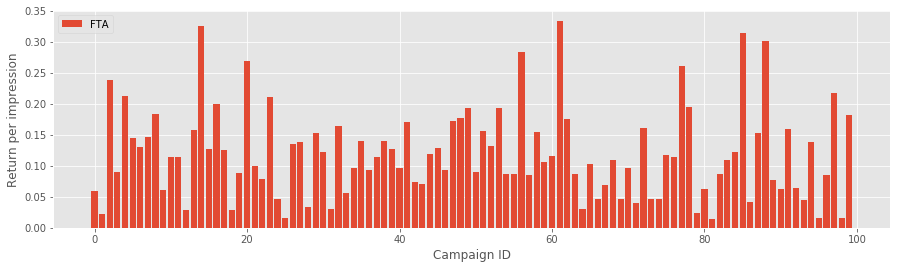

In [89]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

### Last Touch Attribution

* Last Touch Attribution model gives 100% of the credit for a conversion to the last click or visit that happened in a conversion path. If there was no click or visit, then it will credit the last impression.

In [90]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df_Criteo_Attribution)

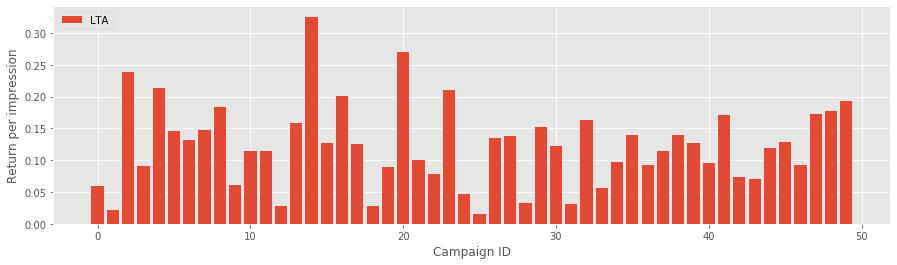

In [91]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [92]:
random.choice(lta,20)

array([0.20042644, 0.13043478, 0.03937008, 0.215311  , 0.08159611,
       0.05172414, 0.20098847, 0.10891089, 0.2       , 0.28139754,
       0.12698413, 0.09572547, 0.07407407, 0.15217391, 0.20733249,
       0.35391924, 0.07594937, 0.18483412, 0.15789474, 0.215311  ])

### Multi-Touch Attribution Models

* Multi-touch attribution is best described in contrast to its counterpart, single-touch attribution.
* In order to divide the revenue credit for a sale properly, multi-touch attribution uses weighted modeling in order to allocate credit to the plethora of influential channels, campaigns, keywords, and touchpoints. 
* Weighted touchpoint modeling assigns a percentage of the revenue credit for a customer to an array touchpoints, as defined by the respective multi-touch attribution model chosen by the organization.
* The models are:
    1. Logistic Regression Model
    2. Time-decay Attribution Model
    3. Linear Attribution Model
    4. U-Shaped Attribution Model

### Logistic Regression Model

* Logistic Regression Analysis aims to reveal touchpoints true contributions.
* The idea of a regression-based approach is straightforward: Each journey is represented as a vector in which each campaign is represented by a binary feature (and can be other event features), a regression model is fit to predict conversions, and the resulting regression coefficients are interpreted as attribution weights.

In [93]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [94]:
x, y = features_for_logistic_regression(df_Criteo_Attribution)
print(np.shape(x))

(120961, 1593)


In [95]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [96]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(max_iter=10000)
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8731451246228248


In [97]:

from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
605/605 [==============================] - 2s 4ms/step - loss: 0.5243 - accuracy: 0.7802 - val_loss: 0.4682 - val_accuracy: 0.8137
Epoch 2/10
605/605 [==============================] - 2s 4ms/step - loss: 0.4443 - accuracy: 0.8201 - val_loss: 0.4330 - val_accuracy: 0.8297
Epoch 3/10
605/605 [==============================] - 2s 3ms/step - loss: 0.4179 - accuracy: 0.8325 - val_loss: 0.4136 - val_accuracy: 0.8392
Epoch 4/10
605/605 [==============================] - 2s 3ms/step - loss: 0.4019 - accuracy: 0.8399 - val_loss: 0.4020 - val_accuracy: 0.8439
Epoch 5/10
605/605 [==============================] - 2s 3ms/step - loss: 0.3913 - accuracy: 0.8451 - val_loss: 0.3938 - val_accuracy: 0.8479
Epoch 6/10
605/605 [==============================] - 2s 3ms/step - loss: 0.3834 - accuracy: 0.8488 - val_loss: 0.3872 - val_accuracy: 0.8482
Epoch 7/10
605/605 [==============================] - 2s 3ms/step - loss: 0.3770 - accuracy: 0.8505 - val_loss: 0.3820 - val_accuracy: 0.8497
Epoch 

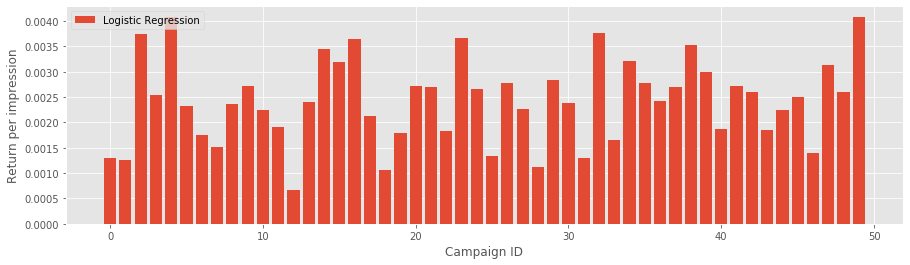

In [98]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx], label = 'Logistic Regression' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

### Time-decay Attribution Model

* The Time Decay model is a multi-touch model that gives more credit to the touchpoints closest to the conversion. It makes the assumption that the closer to the conversion, the more influence it had on the conversion.

In [99]:
df_Criteo_Attribution.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'day',
       'conversion_day'],
      dtype='object')

In [100]:
df_Criteo_Attribution['day']= (df_Criteo_Attribution.timestamp / 86400.).astype(int)
df_Criteo_Attribution['conversion_day']= (df_Criteo_Attribution.conversion_timestamp / 86400.).astype(int)

In [101]:
df_Criteo_Attribution.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'day',
       'conversion_day'],
      dtype='object')

In [102]:
def time_decay_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    def diff_day(conversion_day,day):
        diff=conversion_day-day
        attr= pow(2,-diff/7)
        return attr
    
    df_converted = df[df['conversion']==1]
    df_converted['Attr'] =  df_converted.apply(lambda x:diff_day(x.conversion_day,x.day),axis=1)
    
    def Attr_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx,26])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 29]
        return counters
    
    campaign_conversions = Attr_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions
    
Time_decay_attribution=time_decay_attribution(df_Criteo_Attribution)   

C:\Users\rishv\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


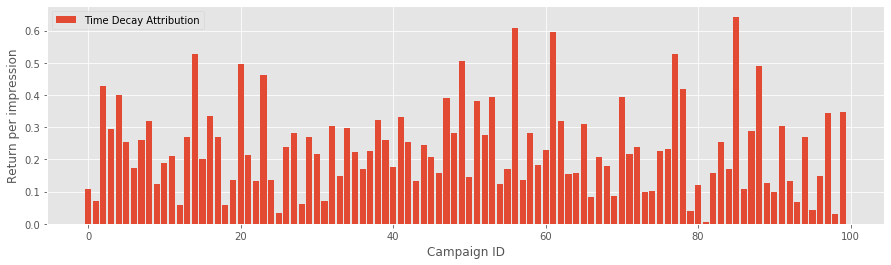

In [103]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(Time_decay_attribution[campaign_idx])), Time_decay_attribution[campaign_idx], label='Time Decay Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

### Linear Attribution

* Linear is the simplest of the multi-touch attribution models. It distributes credit by evenly applying credit to every single touch in the buyer journey.
* The positive is that it is a multi-touch model, so it gives credit to marketing channels throughout the multiple stages of the funnel.
* The negative is that it doesn’t take into account the potential for varying impact of marketing touches

In [104]:
def Linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    df_converted['Linear']=df_converted.conversion/df_converted.click_nb
    
    def Attr_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx,26])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 29]
        return counters
    
    campaign_conversions = Attr_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions
    

In [105]:
Linear_Attr=Linear_attribution(df_Criteo_Attribution)

C:\Users\rishv\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [106]:
Linear_Attr[range(150,250)]

array([0.05455097, 0.01876833, 0.21985081, 0.07878485, 0.17771528,
       0.12751059, 0.12536398, 0.13680715, 0.15653184, 0.05110519,
       0.10354012, 0.10496715, 0.0223172 , 0.13815646, 0.30877425,
       0.11367615, 0.18259628, 0.11069423, 0.02318672, 0.0741677 ,
       0.2593633 , 0.08057551, 0.06912024, 0.20269545, 0.03864951,
       0.01276884, 0.12411348, 0.12013278, 0.03013033, 0.13292276,
       0.10951996, 0.02515894, 0.15112064, 0.04734111, 0.08190843,
       0.12603016, 0.07189735, 0.09211269, 0.12607284, 0.11593329,
       0.08294422, 0.16305556, 0.05637369, 0.06490204, 0.10468565,
       0.11566257, 0.08525749, 0.16160075, 0.15176811, 0.17390862,
       0.08626645, 0.14070568, 0.11239254, 0.16817586, 0.08425313,
       0.07378888, 0.26014841, 0.08173077, 0.14241294, 0.08940657,
       0.10603048, 0.32219046, 0.15811944, 0.07137226, 0.02300094,
       0.08384372, 0.038715  , 0.05667143, 0.09190159, 0.04235137,
       0.08409432, 0.03576951, 0.1316092 , 0.03869569, 0.04047

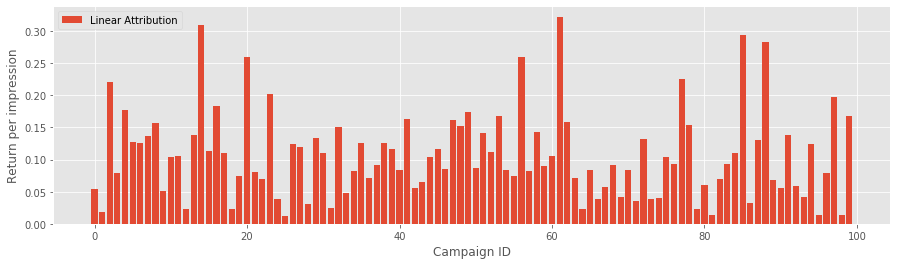

In [107]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(Linear_Attr[campaign_idx])), Linear_Attr[campaign_idx], label='Linear Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

### U-Shape Attribution

* The U-Shaped model, which Google calls Position-Based, is a great multi-touch attribution model for marketing teams that focus on lead generation. 
* It’s a multi-touch model that tracks every single touchpoint, but rather than give equal credit to all touchpoints like the Linear model, it emphasizes the importance of two key touchpoints: 
    1. The anonymous first touch that got the visitor in the door
    2. The lead conversion touch. 
* These two touches get 40% credit each and the remaining touchpoints equally split the remaining 20%.

In [108]:
def U_shape_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    
    def u_shape_calc(click_pos,click_nb):
        default = 0.5
        first_last = 0.4
        inter = 0.2

        if(click_nb == 2):
            return default
        else:
            if(click_pos == click_nb - 1 or click_pos ==0):
                return first_last
            else:
                return inter/(click_nb -2)

    
    def u_shape_value(df_converted):
        x = df_converted.apply(lambda x: u_shape_calc(x.click_pos,x.click_nb),axis=1)
        df_converted['Attribution']=x
        return df_converted
        
    def Attr_by_campaign(df_converted):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_converted)):
            campaign_id = np.argmax(df_converted.iloc[idx,26])
            counters[campaign_id] = counters[campaign_id] + df_converted.iloc[idx, 29]
        return counters
    
    
    df_converted = u_shape_value(df_converted)
    
    #print(df_converted.shape)
    #print(df_converted.head())
    
    campaign_conversions = Attr_by_campaign(df_converted) 
    #campaign_conversions=1
    
        
    return campaign_conversions / campaign_impressions
    
UShape = U_shape_attribution(df_Criteo_Attribution)
    

C:\Users\rishv\anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


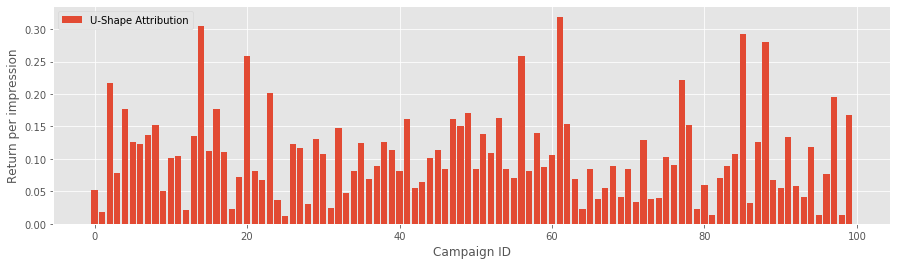

In [109]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(UShape[campaign_idx])), UShape[campaign_idx], label='U-Shape Attribution' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [110]:
print(df_Criteo_Attribution.shape)
df_Criteo_Attribution.columns

(563730, 29)


Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'day',
       'conversion_day'],
      dtype='object')

In [111]:
df_Criteo_Attribution.head(5)

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,day,conversion_day
21537,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,22644417,9312274,21091111,24607497_-1,7.487274e-07,0.163526,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0
430448,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,1795451,29196072,15351056,28474333_-1,7.487274e-07,0.003426,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0
37470,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,9180723,29841067,29196072,7306395_3063962,1.123091e-06,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,16
50751,4,93907,17686799,0,-1,-1,0,1,-1,-1,...,2687461,29841067,21091108,93907_-1,1.497455e-06,0.101299,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0
461757,7,5588915,27491436,0,-1,-1,0,0,-1,-1,...,21857352,29196072,29196072,5588915_-1,2.620546e-06,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0


### Comparison of Models

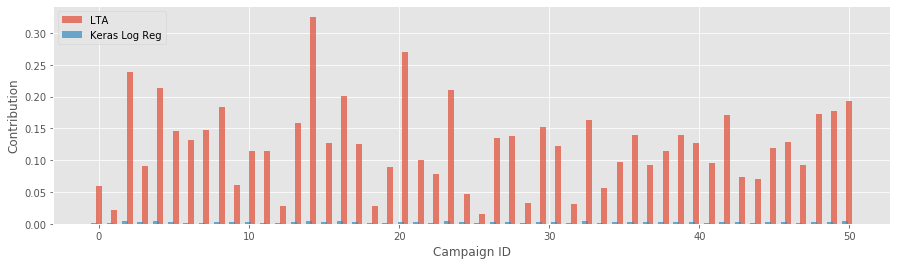

In [73]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(150, 200)
#ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, keras_logreg[campaign_idx], width=0.4, alpha=0.7, label='Keras Log Reg' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

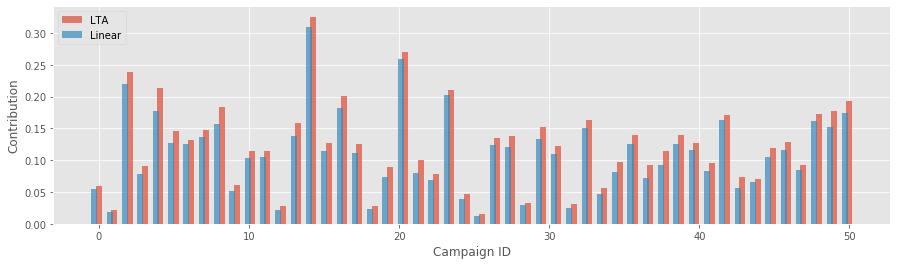

In [72]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(150, 200)
#ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, Linear_Attr[campaign_idx], width=0.4, alpha=0.7, label='Linear' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

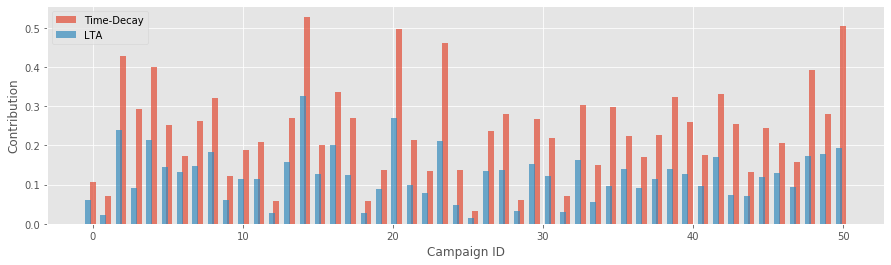

In [68]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(150, 200)
#ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), Time_decay_attribution[campaign_idx], width=0.4, alpha=0.7, label='Time-Decay' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx))-0.3 , lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

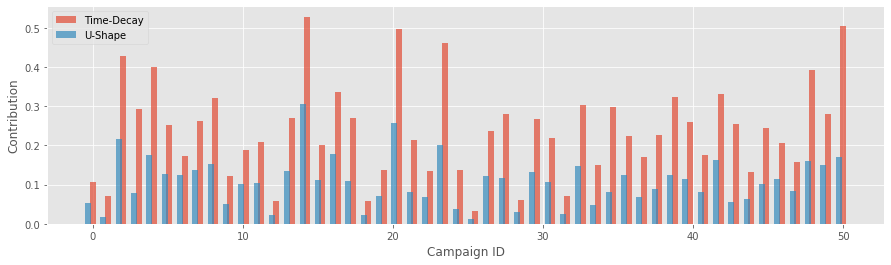

In [69]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(150, 200)
#ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), Time_decay_attribution[campaign_idx], width=0.4, alpha=0.7, label='Time-Decay' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, UShape[campaign_idx], width=0.4, alpha=0.7, label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

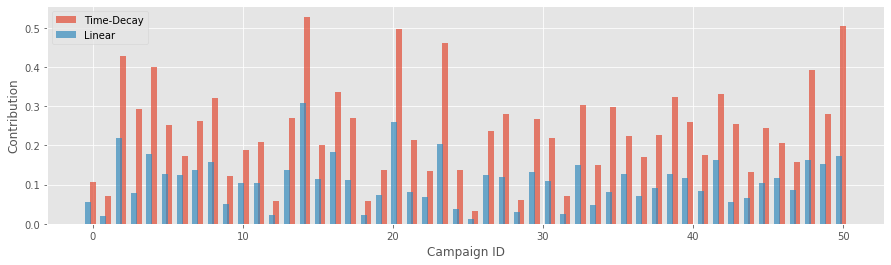

In [70]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(150, 200)
#ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), Time_decay_attribution[campaign_idx], width=0.4, alpha=0.7, label='Time-Decay' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, Linear_Attr[campaign_idx], width=0.4, alpha=0.7, label='Linear' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

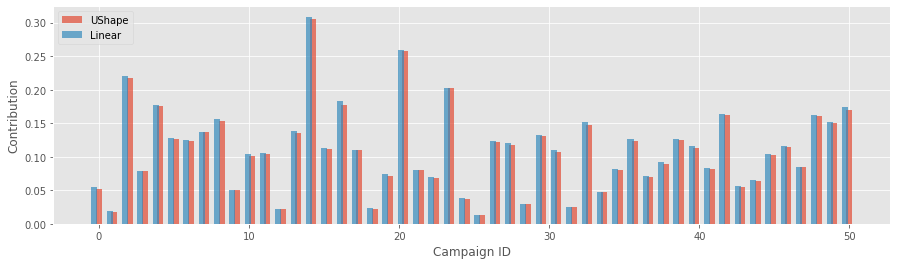

In [74]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(150, 200)
#ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), UShape[campaign_idx], width=0.4, alpha=0.7, label='UShape' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, Linear_Attr[campaign_idx], width=0.4, alpha=0.7, label='Linear' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

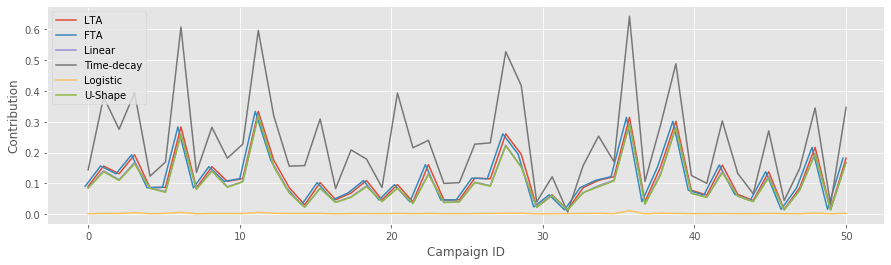

In [78]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
campaign_idx = range(200, 250)
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], label='LTA')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx))-0.2, fta[campaign_idx], label='FTA')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), Linear_Attr[campaign_idx], label='Linear')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), Time_decay_attribution[campaign_idx], label='Time-decay')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), keras_logreg[campaign_idx], label='Logistic')
plt.plot(np.linspace(0, len(campaign_idx), len(campaign_idx)), UShape[campaign_idx], label='U-Shape')

plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

### Budget Optimization and ROI

The campaign simulation idea can be outlined as follows:
1. At the beginning of the process, we distribute a limited budget across the campaigns according to the attribution weights.
2. We replay the available historical events (ordered by their timestamps) and decrement the budgets accordingly.
3. Once a campaign runs out of money, we stop to replay the remaining events associated with it and somehow estimate the probabilities of conversion for all journeys affected by this campaign’s suppression.
4. Finally, we count the total number of conversions and estimate ROI. If none of the campaigns in a converted journey runs out of money before the journey ends, this conversion will be counted explicitly. Otherwise, the estimate of the conversion probability will be used.

In [75]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

In [76]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [82]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, keras_logreg]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df_Criteo_Attribution, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))
        

0 0 : 841
0 1 : 694
1 0 : 537
1 1 : 651
2 0 : 233
2 1 : 622
3 0 : 319
3 1 : 485
4 0 : 389
4 1 : 535
5 0 : 454
5 1 : 801
6 0 : 488
6 1 : 629
7 0 : 538
7 1 : 704


In [ ]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, keras_logreg,fta,Linear_Attr, Time_decay_attribution, UShape]

for i, pitch in enumerate(pitches):
    print('Pitch of Budget Allocation - ' + str(pitch))
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df_Criteo_Attribution, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

Pitch of Budget Allocation - 0.1
0 0 : 841
0 1 : 694
0 2 : 841
0 3 : 839
0 4 : 909
0 5 : 838
Pitch of Budget Allocation - 0.25
1 0 : 537
1 1 : 651
1 2 : 537
1 3 : 519
1 4 : 780
1 5 : 506
Pitch of Budget Allocation - 0.5
2 0 : 233
2 1 : 622
2 2 : 233
2 3 : 233
2 4 : 415
2 5 : 234
Pitch of Budget Allocation - 1.0
3 0 : 319
3 1 : 485
3 2 : 319
3 3 : 330
3 4 : 292
3 5 : 330
Pitch of Budget Allocation - 1.5
4 0 : 389
4 1 : 535
4 2 : 389
4 3 : 416
4 4 : 334
4 5 : 413
Pitch of Budget Allocation - 2.0
5 0 : 454
5 1 : 801
5 2 : 454
5 3 : 477
5 4 : 394
5 5 : 473
Pitch of Budget Allocation - 2.5
6 0 : 488
6 1 : 629
6 2 : 488
6 3 : 528
6 4 : 459
6 5 : 538
Pitch of Budget Allocation - 3.0
7 0 : 538


In [112]:
pitch  = [0.1,0.25,0.5,1.0,1.5,2.0,2.5]
lta_pitch = [841,537,233,319,389,454,488]
linear_pitch = [839,519,233,330,334,477,528]
ushape_pitch = [838,506,234,330,413,473,538]
fta_pitch = [841,537,233,319,389,454,488]
logistic_pitch = [694,651,622,485,535,801,629]
timedecay_pitch = [909,780,415,292,334,394,459]

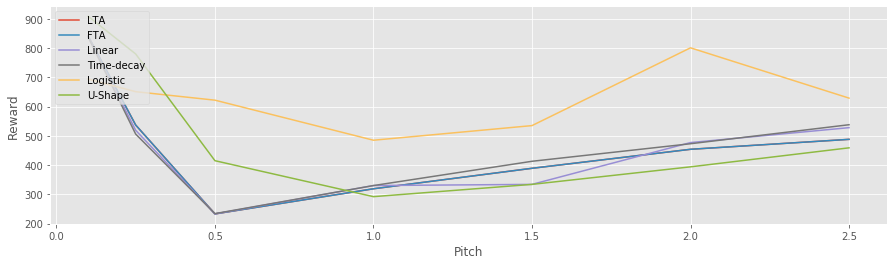

In [113]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.plot(pitch, lta_pitch, label='LTA')
plt.plot(pitch, fta_pitch, label='FTA')
plt.plot(pitch, linear_pitch, label='Linear')
plt.plot(pitch, ushape_pitch, label='Time-decay')
plt.plot(pitch, logistic_pitch, label='Logistic')
plt.plot(pitch, timedecay_pitch, label='U-Shape')

plt.xlabel('Pitch')
plt.ylabel('Reward')
plt.legend(loc='upper left')
plt.show()

In [114]:
## Saving the files to our local 
np.savetxt("lta.txt", lta)
np.savetxt("fta.txt", fta)
np.savetxt("linear.txt", Linear_Attr)
np.savetxt("timedecay.txt", Time_decay_attribution)
np.savetxt("logistic.txt", keras_logreg)
np.savetxt("ushape.txt", UShape)

In [121]:
test = pd.DataFrame(data = (pitch, lta_pitch, fta_pitch, linear_pitch, ushape_pitch,logistic_pitch ,timedecay_pitch)).T
test.columns =['pitch', 'lta_pitch', 'fta_pitch', 'linear_pitch', 'ushape_pitch','logistic_pitch' ,'timedecay_pitch']
test

,pitch,lta_pitch,fta_pitch,linear_pitch,ushape_pitch,logistic_pitch,timedecay_pitch
0,0.10,841.0,841.0,839.0,838.0,694.0,909.0
1,0.25,537.0,537.0,519.0,506.0,651.0,780.0
2,0.50,233.0,233.0,233.0,234.0,622.0,415.0
3,1.00,319.0,319.0,330.0,330.0,485.0,292.0
4,1.50,389.0,389.0,334.0,413.0,535.0,334.0
5,2.00,454.0,454.0,477.0,473.0,801.0,394.0
6,2.50,488.0,488.0,528.0,538.0,629.0,459.0
